In [1]:
from pyspark.sql import SparkSession

import pandas as pd 
import matplotlib.pyplot as plt 

from pyspark.sql.functions import countDistinct, desc, to_timestamp, udf, col
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, StringType

import json

%matplotlib inline

In [2]:
# https://central.sonatype.com/search?q=spark-sql-kafka

# https://spark.apache.org/docs/latest/streaming/structured-streaming-kafka-integration.html

# https://hub.docker.com/r/jupyter/pyspark-notebook/tags?name=spark

# https://central.sonatype.com/artifact/org.apache.spark/spark-sql-kafka-0-10_2.12/3.5.0

spark = (
    SparkSession.builder
      .appName("eda")
      .config("spark.driver.memory", "6g")
      .config("spark.executor.memory", "6g")
      .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0")
      .getOrCreate()
)

In [3]:
spark

In [4]:
spark.version


'3.5.0'

In [5]:
spark.sparkContext._jsc


JavaObject id=o22

In [6]:
# spark.sparkContext._conf.getAll()


In [7]:
spark.sparkContext.getConf().get("spark.jars.packages")


'org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0'

In [8]:
spark.sparkContext._jvm.scala.util.Properties.versionString()


'version 2.12.18'

In [9]:
# (base) jovyan@3d4ee2b03dca:~$ spark-submit --version
# Welcome to
#       ____              __
#      / __/__  ___ _____/ /__
#     _\ \/ _ \/ _ `/ __/  '_/
#    /___/ .__/\_,_/_/ /_/\_\   version 3.5.0
#       /_/
                        
# Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 17.0.8.1
# Branch HEAD
# Compiled by user ubuntu on 2023-09-09T01:53:20Z
# Revision ce5ddad990373636e94071e7cef2f31021add07b
# Url https://github.com/apache/spark
# Type --help for more information.

In [11]:
import socket

# host = "3.80.138.59"
host = "kafka"
port = 9092

sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.settimeout(5)  # 5 second timeout

try:
    sock.connect((host, port))
    print("Connection successful!")
except Exception as e:
    print("Connection failed:", e)
finally:
    sock.close()
    

Connection successful!


In [13]:
# Cells below no longer works
# Do NOT run any cells below
# Just the past example 

# 3.80.138.59:9092 is down 
# but kafka:9092 is connecting fine 
# just nothing in kafka:9092 yet


In [ ]:
df = spark.read.format("kafka") \
                .option("kafka.bootstrap.servers", "3.80.138.59:9092") \
                .option("subscribe", "health_events") \
                .option("startingOffsets", "earliest") \
                .option("endingOffsets", "latest").load()


In [ ]:
df.count()

In [6]:
df.show(2)

+----+--------------------+-------------+---------+------+--------------------+-------------+
| key|               value|        topic|partition|offset|           timestamp|timestampType|
+----+--------------------+-------------+---------+------+--------------------+-------------+
|null|[7B 22 45 76 65 6...|health_events|        0|290358|2024-11-03 19:51:...|            0|
|null|[7B 22 45 76 65 6...|health_events|        0|290359|2024-11-03 19:51:...|            0|
+----+--------------------+-------------+---------+------+--------------------+-------------+
only showing top 2 rows



In [ ]:
def decode_value(x):
    if x is not None:
        try:
            return bytes(x).decode("utf-8")
        except:
            return None


In [ ]:
from pyspark.sql.functions import udf

from pyspark.sql.types import StringType, IntegerType



In [11]:
decode_value_udf = udf(decode_value, StringType())

In [12]:
df = df.withColumn("value_decode", decode_value_udf("value"))

In [14]:
df.show(2, truncate=False)

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+---------+------+-----------------------+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|key |value                                                                                                                                                                                                                                                  

In [15]:
import json

In [ ]:
def get_eventtype(json_str):
    if json_str is not None:
        try:
            d = json.loads(json_str)
            return d["EventType"]
        except:
            return None

    
    

In [17]:
get_eventtype_udf = udf(get_eventtype, StringType())

In [18]:
df = df.withColumn("event_type", get_eventtype_udf("value_decode"))

In [19]:
df.show(2, truncate = False)

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+---------+------+-----------------------+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+
|key |value                                                                                                                                                                                                                                   

In [3]:
df = spark.read.format("kafka") \
               .option("kafka.bootstrap.servers", "3.80.138.59:9092") \
               .option("subscribe", "health_events") \
               .option("startingOffsets", "earliest") \
               .option("endingOffsets", "latest").load() 
                    

In [9]:
df.count()

60875

In [4]:
df.show(2)

+----+--------------------+-------------+---------+------+--------------------+-------------+
| key|               value|        topic|partition|offset|           timestamp|timestampType|
+----+--------------------+-------------+---------+------+--------------------+-------------+
|null|[7B 22 45 76 65 6...|health_events|        0|290358|2024-11-03 19:51:...|            0|
|null|[7B 22 45 76 65 6...|health_events|        0|290359|2024-11-03 19:51:...|            0|
+----+--------------------+-------------+---------+------+--------------------+-------------+
only showing top 2 rows



In [5]:
df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [ ]:

from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

def decode(bs, enc="utf-8"):
    if bs is not None:
        try:
            return bytes(bs).decode(enc)
        except:
            return None
        
decode_udf = udf(decode, StringType())

In [7]:
df = df.withColumn("value_decoded", decode_udf("value"))

In [9]:
df.show(2, truncate = False)

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+---------+------+-----------------------+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|key |value                                                                                                                                                                                                                                                  

In [10]:
import json

def extract_event_type(json_str):
    if json_str is not None:
        try:
            return json.loads(json_str).get("EventType")
        except json.JSONDecodeError:
            return None
    return None

# Step 2: Register the UDF
extract_event_type_udf = udf(extract_event_type, StringType())

# Step 3: Apply the UDF to create the "EventType" column from "value_decoded"
df = df.withColumn("EventType", extract_event_type_udf(col("value_decoded")))


In [11]:
df.select("EventType").show()

+--------------------+
|           EventType|
+--------------------+
|      health_mention|
|         vaccination|
|general_health_re...|
|  hospital_admission|
|     routine_checkup|
|         vaccination|
|         vaccination|
|  emergency_incident|
|  emergency_incident|
|         vaccination|
|         vaccination|
|     routine_checkup|
|      health_mention|
|  emergency_incident|
|  hospital_admission|
|  hospital_admission|
|  hospital_admission|
|  hospital_admission|
|general_health_re...|
|     routine_checkup|
+--------------------+
only showing top 20 rows



In [3]:
df = spark.read.csv("customers-1000000.csv", header = True)

In [4]:
df.count()

1000000

In [5]:
df.printSchema()

root
 |-- Index: string (nullable = true)
 |-- Customer Id: string (nullable = true)
 |-- First Name: string (nullable = true)
 |-- Last Name: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Phone 1: string (nullable = true)
 |-- Phone 2: string (nullable = true)
 |-- Email: string (nullable = true)
 |-- Subscription Date: string (nullable = true)
 |-- Website: string (nullable = true)



In [7]:
df.show(5)

+-----+---------------+----------+---------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+
|Index|    Customer Id|First Name|Last Name|             Company|       City|             Country|             Phone 1|             Phone 2|               Email|Subscription Date|             Website|
+-----+---------------+----------+---------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+
|    1|138fB5315da5fE9|    Jeanne|  Ferrell|          Wilcox-Fox|Tonichester|British Virgin Is...|001-995-820-0140x...|       (757)324-8634|aaronwoods@walter...|       2020-03-27|https://www.romer...|
|    2|b0d61acAc72A388|       Ian| Browning|         Meadows Inc|  Colontown|         El Salvador|        218-383-6764|+1-213-212-0464x0742|zschultz@blevins-...|       2021-03-12|   https://ford.c

In [8]:
### Count number of unique countries

df.select("Country").distinct().count()

243

In [9]:
### Count number of unique countries

df.select("City").distinct().count()

114893

In [ ]:
# Which country has most number of customers

from pyspark.sql.functions import countDistinct, desc, to_timestamp
from pyspark.sql.types import IntegerType, StringType


cust_count_df = df.groupBy("Country").agg(countDistinct("Customer Id").alias("customer_count"))

In [24]:
city_count_df = df.groupBy("Country").agg(countDistinct("City").alias("city_count"))

In [25]:
## Joining

count_df = cust_count_df.join(city_count_df, on = "Country")

In [26]:
count_df.show()

+--------------------+--------------+----------+
|             Country|customer_count|city_count|
+--------------------+--------------+----------+
|                Chad|          4056|      3881|
|            Anguilla|          4049|      3844|
|            Paraguay|          3992|      3809|
|               Macao|          4211|      4032|
|Heard Island and ...|          4095|      3918|
|               Yemen|          4008|      3841|
|             Senegal|          4005|      3822|
|              Sweden|          4094|      3902|
|             Tokelau|          4039|      3849|
|            Kiribati|          4093|      3891|
|French Southern T...|          4018|      3847|
|              Guyana|          4134|      3963|
|         Philippines|          4092|      3893|
|             Eritrea|          4130|      3939|
|              Jersey|          4016|      3827|
|            Djibouti|          4098|      3909|
|      Norfolk Island|          4057|      3834|
|               Tong

In [20]:
count_df.count()

243

In [27]:
count_df = count_df.orderBy(desc("customer_count"))

In [28]:
count_df.show(5)

+--------------------+--------------+----------+
|             Country|customer_count|city_count|
+--------------------+--------------+----------+
|               Korea|          8114|      7358|
|               Congo|          8112|      7421|
|        Saudi Arabia|          4249|      4061|
|Holy See (Vatican...|          4240|      4041|
|               Haiti|          4237|      4041|
+--------------------+--------------+----------+
only showing top 5 rows



In [29]:
count_df = count_df.toPandas()

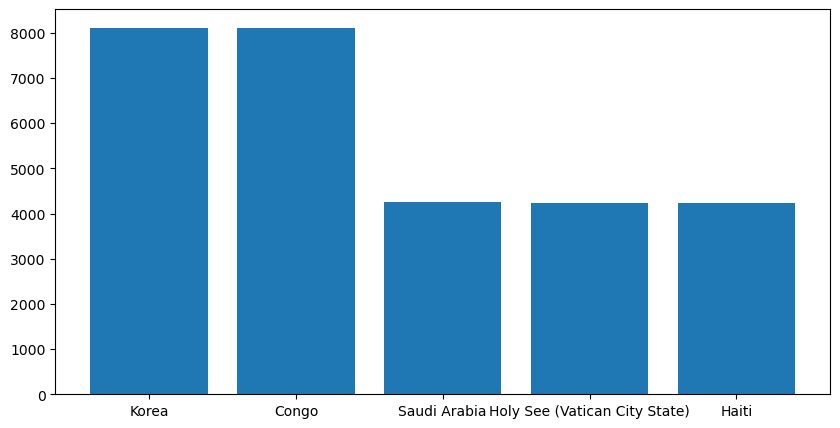

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,5))

plt.bar(count_df['Country'][:5], count_df['customer_count'][:5])

plt.show()

In [32]:
df = df.withColumn("date", to_timestamp("Subscription Date"))

In [33]:
df.show(2)

+-----+---------------+----------+---------+-----------+-----------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+-------------------+
|Index|    Customer Id|First Name|Last Name|    Company|       City|             Country|             Phone 1|             Phone 2|               Email|Subscription Date|             Website|               date|
+-----+---------------+----------+---------+-----------+-----------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+-------------------+
|    1|138fB5315da5fE9|    Jeanne|  Ferrell| Wilcox-Fox|Tonichester|British Virgin Is...|001-995-820-0140x...|       (757)324-8634|aaronwoods@walter...|       2020-03-27|https://www.romer...|2020-03-27 00:00:00|
|    2|b0d61acAc72A388|       Ian| Browning|Meadows Inc|  Colontown|         El Salvador|        218-383-6764|+1-213-212-0464x0742|zschultz@blevins-...|

In [34]:
max_date = df.select(max("date")).collect()[0][0]

In [35]:
max_date

datetime.datetime(2022, 5, 29, 0, 0)

In [36]:
df.filter(df['date'] == max_date).show()

+-----+---------------+-----------+----------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+-------------------+
|Index|    Customer Id| First Name| Last Name|             Company|               City|             Country|             Phone 1|             Phone 2|               Email|Subscription Date|             Website|               date|
+-----+---------------+-----------+----------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+-------------------+
|  860|A087d8CF7E24396|     Connie|Hutchinson|      Hopkins-Reeves|          Karlaside|          Azerbaijan|001-199-101-1344x...|        220.882.7521|josephrodriguez@b...|       2022-05-29|   https://ward.net/|2022-05-29 00:00:00|
| 1023|FfCF2f6f304b4Aa|     Briana|      Khan|       Garner-Bowers|       Sh

In [37]:
df.filter(df['date'] == max_date).count()

1140